In [2]:
# libraries importation
import numpy as np
import random
import os
import PIL
import matplotlib.pyplot as plt

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

from skimage.transform import resize
from sklearn.metrics import confusion_matrix

In [12]:
# libraries importation
from zipfile import ZipFile
  
# specifying the zip file name
file_name = "data/electronic-components-png.zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

File Name                                             Modified             Size
electronic-components-png/background/          2021-06-08 18:36:16            0
electronic-components-png/background/0.png     2021-06-05 16:32:26         2914
electronic-components-png/background/1.png     2021-06-05 16:32:26         3130
electronic-components-png/background/10.png    2021-06-05 16:32:26         2238
electronic-components-png/background/11.png    2021-06-05 16:32:26         3001
electronic-components-png/background/12.png    2021-06-05 16:32:26         2628
electronic-components-png/background/13.png    2021-06-05 16:32:26         2623
electronic-components-png/background/14.png    2021-06-05 16:32:26         2857
electronic-components-png/background/15.png    2021-06-05 16:32:28         2627
electronic-components-png/background/16.png    2021-06-05 16:32:28         3133
electronic-components-png/background/17.png    2021-06-05 16:32:28         2784
electronic-components-png/background/18.

In [3]:
image_path = "wire_label_content_1.PNG"
# Read the image and convert it to grayscale
img = PIL.Image.open(image_path).convert("L")
print(img)

<PIL.Image.Image image mode=L size=212x89 at 0x7F0030AC8DD8>


In [4]:
# Load the dataset
DATASET_PATH = "./electronic-components-png/"

# Define the target images resolution
TARGET_WIDTH = 28
TARGET_HEIGHT = 28

# iNVERT IMAGE (dark background can sometimes improve accuracy)
INVERT = False

# Set aside 20% for validation and 20% for test
VAL_RATIO = 0.2
TEST_RATIO = 0.2

# seed for validation set split
random.seed(42)

In [5]:
### Load images as Numpy arrays

# We want to record the labels and assign a ground truth label as a number to each sample
labels = []
y_all = []    # y=1D vector of the ground labels (n)
X_all = []    # X=3D array of all image samples (n x width x height)

# Find the directories in the dataset folder (skip the Jupyter Notebook checkpoints hidden folder)
for label in os.listdir(DATASET_PATH):
    class_dir = os.path.join(DATASET_PATH, label)
    if os.path.isdir(class_dir) and label != ".ipynb_checkpoints":

    # Add the name of the folder to our labels list
        labels.append(label)

    # Go through each image in the folder
        for i, file in enumerate(os.listdir(class_dir)):

      # Skip the Jupyter Notebook checkpoints folder that sometimes gets added
            if file != ".ipynb_checkpoints":

        # Open image and convert to grayscale
                file_path = os.path.join(class_dir, file)
                img = PIL.Image.open(file_path).convert('L')

        # Convert the image to a Numpy array, optionally invern, and append to X
                img_array = np.asarray(img)
                if INVERT:
            
                    img_array = 255 - img_array
                X_all.append(img_array)

        # Add label to the y array
                y_all.append(label)

    # Show how many images we loaded
    print("Added", str(i + 1), "images from", label)

# Calculate total number of samples
num_samples = len(X_all)

# Sort the labels list by alphabetical order
labels = sorted(labels)

# Print out labels and number of samples
print(labels)
print("Number of samples:", num_samples)

Added 50 images from diode
Added 50 images from led
Added 50 images from resistor
Added 50 images from background
Added 50 images from capacitor
['background', 'capacitor', 'diode', 'led', 'resistor']
Number of samples: 250


In [6]:
### Convert the label to numbers

# Show the labels before the conversion
print("Before:", y_all)

# Convert each label to its index in the labels
y_out = []
for i, label in enumerate(y_all):
    y_out.append(labels.index(label))
y_all = y_out

# Show the labels after the conversion
print("After:", y_all)

Before: ['diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'diode', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor', 'resistor',

In [7]:
### Shuffle samples and labels together, divide into test, validation and training sets

# Shuffle samples and associated labels together
#from zipfile import ZipFile as zip

X_y = list(zip(X_all, y_all)) # we zip and pair each image with its label
# shuffle
random.shuffle(X_y)
# unzip the shuffled data
X_all, y_all = zip(*X_y)

# Calculate the number of validation and test samples to put aside (round down)
num_samples_test = int(TEST_RATIO * num_samples)
num_samples_val = int(VAL_RATIO * num_samples)

# The first "num_samples_test" samples of the shuffled list become the test set
X_test = X_all[:num_samples_test]
y_test = y_all[:num_samples_test]

# The next "num_samples_test" samples of the shuffled list become the validation set
X_val = X_all[num_samples_test:(num_samples_test+num_samples_val)]
y_val = y_all[num_samples_test:(num_samples_test+num_samples_val)]

# The remaining samples become the training set
X_train = X_all[(num_samples_test+num_samples_val):]
y_train = y_all[(num_samples_test+num_samples_val):]

# Remember the number of samples in the test set
num_samples_train = len(X_train)

# Print out the number of test, validation and training samples
print("Number of test samples:", num_samples_test)
print("Number of validation samples:", num_samples_val)
print("Number of training samples:", num_samples_train)

Number of test samples: 50
Number of validation samples: 50
Number of training samples: 150


Label: 4 (resistor)
[[149 149 149 ... 157 157 157]
 [149 149 149 ... 157 157 157]
 [149 149 149 ... 157 157 157]
 ...
 [131 133 133 ... 163 163 163]
 [131 131 133 ... 163 163 163]
 [131 131 131 ... 163 163 163]]


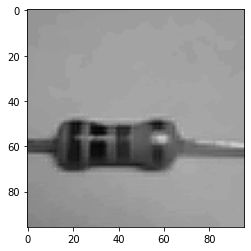

In [8]:
### view one of the training samples

# choose which sample you want to view
idx = 0

# print out label (number and string) and part of the array
print("Label: "+str(y_train[idx]) + " (" + labels[y_train[idx]] + ")" )
print(X_train[idx])

# Display image from array
plt.imshow(X_train[idx], cmap='gray', vmin=0, vmax=255)

In [9]:
### Function to resize list of images
def resize_images(images,width, height, anti_aliasing=True):
    X_out = []
    for i, img in enumerate(images):
        X_out.append(resize(img, (height, width), anti_aliasing=anti_aliasing))
    return X_out

In [10]:
### Scale/crop images

# Resize (scale) all images in the training set
X_train = resize_images(X_train, TARGET_WIDTH, TARGET_HEIGHT)

# Resize (scale) all images in the validation set
X_val = resize_images(X_val, TARGET_WIDTH, TARGET_HEIGHT)

# Resize (scale) all images in the training set
X_test = resize_images(X_test, TARGET_WIDTH, TARGET_HEIGHT)

/opt/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Label: 4 (resistor)


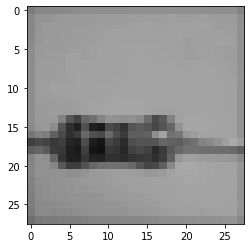

In [12]:
### View training sample after being resized

### view one of the training samples

# choose which sample you want to view
idx = 0

# print out label (number and string) and part of the array
print("Label: "+str(y_train[idx]) + " (" + labels[y_train[idx]] + ")" )
#print(X_train[idx])

# Display image from array
plt.imshow(X_train[idx], cmap='gray', vmin=0, vmax=1)

In [13]:
# Convet a list of samples and labels into Numpy arrays

# Training set
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

# Validation set
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)

# Testing set
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

print("Training X:", X_train.shape)
print("Training y:", y_train.shape)
print("Validation X:", X_val.shape)
print("Validation y:", y_val.shape)
print("Testing X:", X_test.shape)
print("Tesing y:", y_test.shape)

Training X: (150, 28, 28)
Training y: (150,)
Validation X: (50, 28, 28)
Validation y: (50,)
Testing X: (50, 28, 28)
Tesing y: (50,)


In [14]:
### Flatten each image to a 1D vector (DNN requires 1D input)

# Compute length of 1D array that will flatten each image
len_vector = TARGET_WIDTH * TARGET_HEIGHT

# Flatten matricies to vectors
X_train = X_train.reshape(num_samples_train, len_vector)
X_val = X_val.reshape(num_samples_val, len_vector)
X_test = X_test.reshape(num_samples_test, len_vector)

# Determine the input shape for our keras model
input_shape = (X_train.shape[1],)

print(" X train:", X_train.shape)
print(" y train:", y_train.shape)
print(" X validation:", X_val.shape)
print(" y validation:", y_val.shape)
print(" X test:", X_test.shape)
print(" y test:", y_test.shape)
print("Input tensor shape:", input_shape)

 X train: (150, 784)
 y train: (150,)
 X validation: (50, 784)
 y validation: (50,)
 X test: (50, 784)
 y test: (50,)
Input tensor shape: (784,)


In [15]:
### Convert labels (integers) to one-hot encoding

# Get the number of classes
num_classes = len(labels)

# Use keras's np.utils to create one-hot encoding (note that the capital "Y" is 2D array)
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_val = np_utils.to_categorical(y_val, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

print("Y Train:", Y_train.shape)
print("Y Val:", Y_val.shape)
print("Y Test:", Y_test.shape)

for i in range(5):
    print("Label:" + str(y_train[i]) + " |One-hot:", Y_train[i])

Y Train: (150, 5)
Y Val: (50, 5)
Y Test: (50, 5)
Label:4 |One-hot: [0. 0. 0. 0. 1.]
Label:4 |One-hot: [0. 0. 0. 0. 1.]
Label:1 |One-hot: [0. 1. 0. 0. 0.]
Label:1 |One-hot: [0. 1. 0. 0. 0.]
Label:1 |One-hot: [0. 1. 0. 0. 0.]


In [16]:
### Construct the keras model

# A sequential model is a linear stack of layers
model = Sequential()

model.add(Dense(64, input_shape=input_shape))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(64, input_shape=input_shape))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(num_classes, input_shape=input_shape))
model.add(Activation('softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["acc"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 3

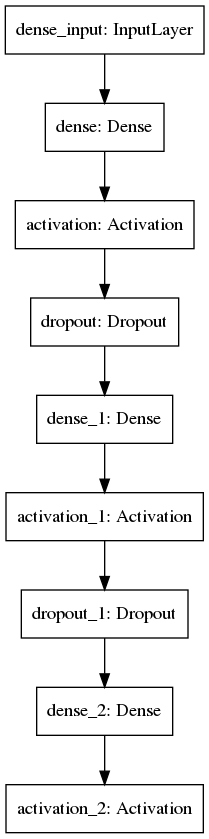

In [18]:
import tensorflow as tf
tf.keras.utils.plot_model(
    model,
    to_file="model.png",)

In [19]:
history = model.fit(X_train, Y_train, epochs=200, batch_size=32,
                   verbose=1, validation_data=(X_test, Y_test))

Epoch 1/200
5/5 [==============================] - 1s 54ms/step - loss: 1.8222 - acc: 0.1467 - val_loss: 1.6287 - val_acc: 0.1600
Epoch 2/200
5/5 [==============================] - 0s 11ms/step - loss: 1.6912 - acc: 0.2467 - val_loss: 1.5741 - val_acc: 0.1600
Epoch 3/200
5/5 [==============================] - 0s 11ms/step - loss: 1.6067 - acc: 0.2667 - val_loss: 1.5677 - val_acc: 0.3400
Epoch 4/200
5/5 [==============================] - 0s 10ms/step - loss: 1.6023 - acc: 0.2867 - val_loss: 1.5340 - val_acc: 0.5200
Epoch 5/200
5/5 [==============================] - 0s 12ms/step - loss: 1.5337 - acc: 0.3133 - val_loss: 1.4865 - val_acc: 0.3800
Epoch 6/200
5/5 [==============================] - 0s 10ms/step - loss: 1.5237 - acc: 0.3267 - val_loss: 1.4315 - val_acc: 0.4800
Epoch 7/200
5/5 [==============================] - 0s 9ms/step - loss: 1.5222 - acc: 0.3267 - val_loss: 1.4045 - val_acc: 0.4200
Epoch 8/200
5/5 [==============================] - 0s 8ms/step - loss: 1.3986 - acc: 0.4733

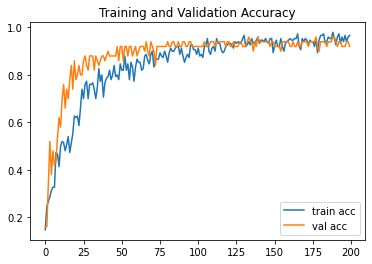

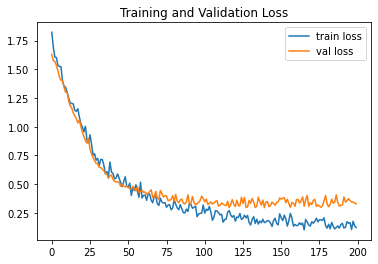

In [20]:
### Plot the training and validation accuracy and loss over time

# plotting the accuracy
plt.plot(history.history['acc'], label='train acc')
plt.plot(history.history['val_acc'], label='val acc')
plt.legend()
plt.title("Training and Validation Accuracy")
plt.savefig('./acc_plot.png')
plt.show()


# plotting the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.savefig('./loss_plot.png')
plt.show()

## Predicion

In [21]:
### predicting label with one validation sample (inference)
def prediction(image_index):
# Change this to try a different sample from the test set
    idx = image_index

    # Make sample 2D array instead of 1D vector (this is what the Keras model expects as input)
    x = np.expand_dims(X_val[idx], 0)

    # Make prediction using trained model
    y_pred = model.predict(x)

    # Find index of highest score in output
    predicted_label = np.argmax(y_pred)
    actual_label = np.argmax(Y_val[idx])

    # Display model output, predicted label, actual label
    print("Model output:", y_pred)
    print("Predicted label:", predicted_label, "-", labels[predicted_label])
    print("Actual label:", actual_label, "-", labels[actual_label])
    plt.imshow((X_val[idx].reshape(28,28,1)), cmap='gray', vmin=0, vmax=1)

Model output: [[3.52055824e-04 1.35742041e-04 1.14942364e-01 7.23043995e-05
  8.84497523e-01]]
Predicted label: 4 - resistor
Actual label: 4 - resistor


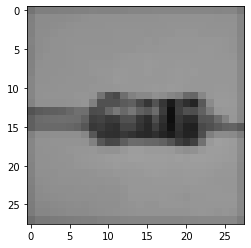

In [22]:
prediction(11)

Model output: [[3.4957461e-04 9.9520326e-01 7.8932128e-05 3.4322396e-03 9.3600550e-04]]
Predicted label: 1 - capacitor
Actual label: 1 - capacitor


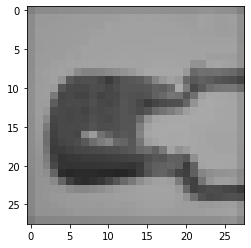

In [23]:
prediction(49)

Model output: [[6.4328889e-09 4.2629914e-04 1.7093849e-06 9.9953187e-01 4.0104940e-05]]
Predicted label: 3 - led
Actual label: 3 - led


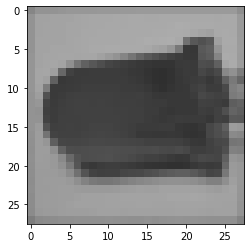

In [24]:
prediction(45)

In [25]:
### Create confusion matrix from validation set

# Find predictions from all validation samples
Y_pred = model.predict(X_val)
print("Validation output shape:", Y_pred.shape)

# Convert actual and predicted validation one-hot encoding to numerical labels
y_val = np.argmax(Y_val, axis=1)
y_pred = np.argmax(Y_pred, axis=1)

# Print some values from actual and predicted validation sets (first 50 samples)
print("Actual validation labels:\t", y_val[:50])
print("Predicted validation labels:\t", y_pred[:50])

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)
cm = np.transpose(cm)

# Print confusion matrix
print()
print("                         ---> Predicted labels")
print("|")
print("v Actual labels")
print("\t\t\t" + ' '.join("{!s:6}".format('(' + str(i) + ')') for i in range(num_classes)))
for row in range(num_classes):
    print("{:>12} ({}):  [{}]".format(labels[row], row, ' '.join("{:6}".format(i) for i in cm[row])))

Validation output shape: (50, 5)
Actual validation labels:	 [4 4 0 4 2 3 1 3 1 2 3 4 4 4 1 2 1 2 1 2 0 0 1 4 0 1 2 1 0 3 3 2 0 2 1 1 3
 2 2 0 0 1 2 4 0 3 2 4 1 1]
Predicted validation labels:	 [4 4 0 4 4 3 1 3 1 2 3 4 4 4 1 2 1 2 1 2 0 0 1 4 0 1 4 1 0 3 3 2 0 2 1 1 3
 2 2 0 0 1 2 4 0 3 4 4 1 1]

                         ---> Predicted labels
|
v Actual labels
			(0)    (1)    (2)    (3)    (4)   
  background (0):  [     9      0      0      0      0]
   capacitor (1):  [     0     13      0      0      0]
       diode (2):  [     0      0      9      0      0]
         led (3):  [     0      0      0      7      0]
    resistor (4):  [     0      0      3      0      9]


## Evaluation

In [28]:
### Evaluate model on validation set
score = model.evaluate(X_val, Y_val)
print("Validation loss:", score[0])
print("Validation accuracy:", round(score[1]*100),"%")

2/2 [==============================] - 0s 3ms/step - loss: 0.1195 - acc: 0.9400
Validation loss: 0.11951747536659241
Validation accuracy: 94 %


In [29]:
### Evaluate model on entire test set
score = model.evaluate(X_test, Y_test)
print("Test loss:", score[0])
print("Test accuracy:", round(score[1]*100),"%")

2/2 [==============================] - 0s 3ms/step - loss: 0.3285 - acc: 0.9200
Test loss: 0.3284856379032135
Test accuracy: 92 %
